### Libraries

In [519]:
#Data Manipulation
import pandas as pd
import numpy as np
#Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
import itertools
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#ML Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Tensorflow
import tensorflow as tf
from keras.layers import LSTM, Dense, InputLayer
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.losses import MeanAbsoluteError
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError


warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .60,
        "validationSize": .20,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    },
    "lstm":{
        "epochs": 200,
        "batch_size": 64,
        "lr": 0.00001
    }
}

In [520]:
def plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=y_train, mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_val_dates, y=y_val, mode="lines", name="Validation"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=y_test, mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Consumption [kWh]",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.write_image("../results/dataset_split.png", width=1000, scale=2, format="png")
    fig.show()

In [521]:
def plotPredictions(dates, y_pred, y_test, filename=None):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Consumption [kWh]",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    if filename is not None:
        fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()

In [522]:
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test)

    mae_ref = mean_absolute_error(np.exp(y_test), np.exp(y_pred))

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted)
        mae_permuted = mean_absolute_error(np.exp(y_test), np.exp(y_pred_permuted))

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Permutation Feature Importance')
    plt.savefig('../results/PermutationFeatureImportance.png', bbox_inches='tight', dpi=300)
    plt.show()

In [523]:
def calculate_metrics(y_true, y_pred): 
    epsilon = 1e-10   
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)
    # RMSE (Root Mean Squared Error)
    rmse = root_mean_squared_error(y_true, y_pred)
    # MdAPE (Median Absolute Percentage Error)
    mdape = np.median(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), epsilon, None))) * 100
    # MAAPE (Mean ArcTangent Percentage Error)
    maape = np.mean(np.arctan(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), epsilon, None)))) * 100

    return mae, rmse, mdape, maape

def median_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(float).eps
    y_true_clipped = np.clip(np.abs(y_true), epsilon, None)

    percentage_errors = np.abs((y_true - y_pred) / y_true_clipped) * 100

    mdape_value = np.median(percentage_errors)
    
    return mdape_value

def plot_metrics(train_data, validation_data, train_names, val_names, yaxis_title, parameters):
    epochs_list = np.arange(0, parameters["lstm"]["epochs"])
    fig = go.Figure()
    for train, name in zip(train_data, train_names):
        trace = go.Scatter(x = epochs_list, y=train, name=name, mode="lines")
        fig.add_trace(trace)

    if validation_data is not None:
        for validation, name in zip(validation_data, val_names):
            trace = go.Scatter(x = epochs_list, y=validation, name=name, mode="lines")
            fig.add_trace(trace)

    fig.update_layout(
        title = "Metrics in Training/Validation",
        xaxis_title = "Epoch",
        yaxis_title = yaxis_title,
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

In [524]:
def plotLosses(train_loss, validation_loss, parameters):
    epochs_list = np.arange(0, int(parameters["lstm"]["epochs"]))
    fig = go.Figure()
    trace1 = go.Scatter(x=epochs_list, y=train_loss, name="Training Loss", mode="lines")
    fig.add_trace(trace1)
    if validation_loss is not None:
        trace2 = go.Scatter(x=epochs_list, y=validation_loss, name="Validation Loss", mode="lines")
        fig.add_trace(trace2)
    fig.update_layout(
        title = "Training and Validation Losses",
        xaxis_title = "Epoch",
        yaxis_title = "MSE Loss Value",
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

In [525]:
#Create LSTM Model
from keras import ops
def create_LSTM_Model(num_features, n_units, n_layers, dropout):
    model = Sequential()
    model.add(InputLayer((num_features, 1)))
    for _ in range(n_layers - 1):
        model.add(LSTM(units=n_units, activation='tanh',kernel_initializer='glorot_normal', return_sequences=True, dropout=dropout))
    model.add(LSTM(units=n_units, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(80, activation='linear'))
    model.add(Dense(1, activation='linear'))
    return model

def maape_fn(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_true_abs = tf.abs(y_true)
    
    y_true_clipped = tf.clip_by_value(y_true_abs, epsilon, float('inf'))
    
    percentage_errors = tf.abs((y_true - y_pred) / y_true_clipped)
    maape = tf.reduce_mean(tf.atan(percentage_errors)) * 100
    
    return maape

def mdape_fn(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_true_abs = tf.abs(y_true)
    
    y_true_clipped = tf.clip_by_value(y_true_abs, epsilon, float('inf'))
    
    percentage_errors = tf.abs((y_true - y_pred) / y_true_clipped)
    mdape = ops.median(percentage_errors) * 100
    
    return mdape

def train_model(model, X, y, parameters, validation_data=None, verbose=False):
    if not isinstance(X, np.ndarray):
        X = X.to_numpy()
    if not isinstance(y, np.ndarray):
        y = y.to_numpy()
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y = y.reshape((y.shape[0], 1))

    
    model.compile(
        loss = "mse", 
        optimizer=Adam(learning_rate=parameters["lstm"]["lr"]), 
        metrics=[
            MeanAbsoluteError(),
            RootMeanSquaredError(),
            mdape_fn,
            maape_fn
        ]
    )
    if validation_data is not None:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        return model.fit(
            X, 
            y, 
            epochs=parameters["lstm"]["epochs"],
            batch_size = parameters["lstm"]["batch_size"],
            validation_data = (validation_data[0], validation_data[1]),
            verbose=verbose, 
            callbacks=[early_stopping]
        )
    else:
        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        return model.fit(
            X,
            y,
            epochs=parameters["lstm"]["epochs"],
            batch_size = parameters["lstm"]["batch_size"],
            verbose=verbose,
            callbacks=[early_stopping]
        )

In [526]:
def addNLags(df, lags_list):
    lag_df = df.copy()
    for lag in lags_list:
        lag_df[f'lag_{lag}'] = lag_df["Consumo"].shift(lag * 24)

    return lag_df.fillna(0)

def parseData(df):
    for col in df:
        if col != "Date":
            df[col] = df[col].astype(float)
    return df

def normalize(df, columns_to_normalize, min_val=0, max_val=1):

    df_to_normalize = df[columns_to_normalize]
    df_non_normalized = df.drop(columns=columns_to_normalize)

    #scaler = MinMaxScaler(feature_range=(min_val, max_val))
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(df_to_normalize)

    df_normalized = pd.DataFrame(data_normalized, columns=columns_to_normalize, index=df.index)
    df_final = pd.concat([df_normalized, df_non_normalized], axis=1)


    return df_final[df.columns]

### Split Dataset

In [527]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]

df = df.drop(columns=["Date"], axis=1)
df = parseData(df)
df.columns = df.columns.map(str)

y = df["Consumo"]

X = df.drop(columns=["Consumo", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
X = normalize(X, X.columns)
col_names = list(X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_val, y_val = X.loc[trainingSize:validationSize, :].copy(), y.loc[trainingSize:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Validation Size:{len(X_val)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12048
Training Size:7229
Validation Size:2410
Test Size: 2411


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday'],
      dtype='object')

In [528]:
plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test)

## Possible Models

### SARIMAX

In [529]:
df_sarimax = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df_sarimax["Date"] = pd.to_datetime(df_sarimax["Date"])
df_sarimax = parseData(df_sarimax)
df_sarimax = normalize(df_sarimax, col_names)
train = df_sarimax.loc[:validationSize].copy()
test = df_sarimax.loc[validationSize:].copy()
model = SARIMAX(train['Consumo'], exog=train[col_names], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
model_fit = model.fit(disp=False)
forecast = model_fit.get_forecast(steps=len(test), exog=test[col_names])
forecast_mean = forecast.predicted_mean   

In [530]:
mae, rmse, mdape, maape = calculate_metrics(test["Consumo"].values, forecast_mean.values)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")
plotPredictions(test["Date"], forecast_mean, test["Consumo"])

MAE: 2.926926557557706, RMSE: 4.641225181878134, MAAPE: 75.82819043711542, MdAPE: 80.76194437742889


In [531]:
plotPredictions(X_test_dates[:30*24], forecast_mean.values[:30*24], y_test.values[:30*24])

### KNN

In [532]:
knn = KNeighborsRegressor(n_neighbors=20, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")

MAE: 1.8316241559344701, RMSE: 3.2603478380586943, MAAPE: 54.6132306773337, MdAPE: 33.31924027928723


In [533]:
plotPredictions(X_test_dates, y_pred, y_test)

In [534]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

In [535]:
plotPredictions(X_test_dates[:7*24], y_pred[:7*24], y_test[:7*24])

### LightGBM

In [536]:
lgbm = LGBMRegressor(objective="regression", boosting_type='gbdt', n_estimators=1000, learning_rate=0.01, random_state=123, n_jobs=-1, early_stopping_rounds=100, verbose=100)
lgbm.fit(X_train, y_train, eval_metric="mae", eval_set=[(X_val, y_val)])
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)
mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.837391
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.152253
[LightGBM] [Debug] init for col-wise cost 0.000801 seconds, init for row-wise cost 0.001520 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 7229, number of used features: 11
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 4.195463
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
Training until validation scores don't improve for 100 rounds
[

In [537]:
plotPredictions(X_test_dates, y_pred, y_test)

In [538]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

### XGBoost

In [539]:
xgboost = XGBRegressor(n_estimators=1000, random_state=123, learning_rate=0.03, max_depth=7, verbose=0)
xgboost.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
           eval_metric='mae', 
           early_stopping_rounds=100)
y_pred = xgboost.predict(X_test)
mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")

[0]	validation_0-mae:4.46225
[1]	validation_0-mae:4.42853
[2]	validation_0-mae:4.39547
[3]	validation_0-mae:4.36575
[4]	validation_0-mae:4.33801
[5]	validation_0-mae:4.30805
[6]	validation_0-mae:4.28178
[7]	validation_0-mae:4.25461
[8]	validation_0-mae:4.22698
[9]	validation_0-mae:4.20456
[10]	validation_0-mae:4.17969
[11]	validation_0-mae:4.15862
[12]	validation_0-mae:4.13372
[13]	validation_0-mae:4.11188
[14]	validation_0-mae:4.09042
[15]	validation_0-mae:4.07240
[16]	validation_0-mae:4.05454
[17]	validation_0-mae:4.03652
[18]	validation_0-mae:4.01923
[19]	validation_0-mae:4.00119
[20]	validation_0-mae:3.98544
[21]	validation_0-mae:3.96990
[22]	validation_0-mae:3.95355
[23]	validation_0-mae:3.94078
[24]	validation_0-mae:3.92663
[25]	validation_0-mae:3.91095
[26]	validation_0-mae:3.89953
[27]	validation_0-mae:3.88571
[28]	validation_0-mae:3.87365
[29]	validation_0-mae:3.86164
[30]	validation_0-mae:3.84820
[31]	validation_0-mae:3.83666
[32]	validation_0-mae:3.82579
[33]	validation_0-ma

In [540]:
plotPredictions(X_test_dates, y_pred, y_test)

In [541]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

### Long Short-Term Memory (LSTM) with Validation Set

In [542]:
lstm = create_LSTM_Model(
    num_features = X_train.shape[1], 
    n_units = 64, 
    n_layers = 2, 
    dropout = 0.2) 
lstm.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_47 (LSTM)                  │ (None, 11, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 80)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,201 (215.63 KB)

 Trainable params: 55,201 (215.63 KB)

 Non-trainable params: 0 (0.00 B)

In [543]:
train_history = train_model(
    model = lstm, 
    X = X_train, 
    y = y_train, 
    parameters = parameters,
    validation_data = (X_val, y_val),
    verbose = True)

y_pred = lstm.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
).flatten()
mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")

Epoch 1/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 44.8745 - maape_fn: 91.1693 - mdape_fn: 99.9265 - mean_absolute_error: 4.1423 - root_mean_squared_error: 6.6973 - val_loss: 85.7935 - val_maape_fn: 92.1698 - val_mdape_fn: 99.3603 - val_mean_absolute_error: 5.0823 - val_root_mean_squared_error: 9.2625
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 48.1814 - maape_fn: 90.7357 - mdape_fn: 99.0193 - mean_absolute_error: 4.2237 - root_mean_squared_error: 6.9375 - val_loss: 85.4483 - val_maape_fn: 91.6486 - val_mdape_fn: 98.4184 - val_mean_absolute_error: 5.0607 - val_root_mean_squared_error: 9.2438
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 46.2615 - maape_fn: 89.9206 - mdape_fn: 97.8989 - mean_absolute_error: 4.1424 - root_mean_squared_error: 6.8010 - val_loss: 85.0614 - val_maape_fn: 91.0352 - val_mdape_fn: 97.3450 - val_mean_absolute_error: 5.0354 - val_root_mean_squared_error: 9.2229
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - l

In [544]:
plotPredictions(X_test_dates, y_pred, y_test)

In [545]:
plotLosses(train_history.history["loss"], train_history.history["val_loss"], parameters)

In [546]:
# MAE and RMSE
plot_metrics(
    train_data = [train_history.history["root_mean_squared_error"], train_history.history["mean_absolute_error"]], 
    validation_data = [train_history.history["val_root_mean_squared_error"], train_history.history["val_mean_absolute_error"]], 
    train_names = ["Training RMSE", "Training MAE"],
    val_names = ["Validation RMSE", "Validation MAE"],
    yaxis_title = "RMSE / MAE",
    parameters = parameters
)

In [547]:
# MAPE and MdAPE
plot_metrics(
    train_data = [train_history.history["maape_fn"], train_history.history["mdape_fn"]], 
    validation_data = [train_history.history["val_maape_fn"], train_history.history["val_mdape_fn"]], 
    train_names = ["Training MAAPE", "Training MdAPE"],
    val_names = ["Validation MAAPE", "Validation MdAPE"],
    yaxis_title = "MAAPE / MdAPE",
    parameters = parameters
)

### LSTM without Validation Set

In [548]:
lstm = create_LSTM_Model(
    num_features = X_train.shape[1], 
    n_units = 64, 
    n_layers = 2, 
    dropout = 0.2) 
lstm.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                  │ (None, 11, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 80)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,201 (215.63 KB)

 Trainable params: 55,201 (215.63 KB)

 Non-trainable params: 0 (0.00 B)

In [549]:
train_history = train_model(
    model = lstm, 
    X = np.concatenate([X_train, X_val], axis=0), 
    y = np.concatenate([y_train, y_val], axis=0),
    parameters = parameters,
    validation_data=None,
    verbose = True)

y_pred = lstm.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
).flatten()
mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, MAAPE: {maape}, MdAPE: {mdape}")

Epoch 1/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 59.7070 - maape_fn: 91.5486 - mdape_fn: 99.6078 - mean_absolute_error: 4.4438 - root_mean_squared_error: 7.7228
Epoch 2/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 53.6825 - maape_fn: 91.1829 - mdape_fn: 98.4002 - mean_absolute_error: 4.2727 - root_mean_squared_error: 7.3258
Epoch 3/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 57.6897 - maape_fn: 89.9013 - mdape_fn: 96.8835 - mean_absolute_error: 4.3707 - root_mean_squared_error: 7.5928
Epoch 4/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 58.1369 - maape_fn: 88.3692 - mdape_fn: 94.4958 - mean_absolute_error: 4.3188 - root_mean_squared_error: 7.6215
Epoch 5/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 54.5073 - maape_fn: 84.5839 - mdape_fn: 90.0607 - mean_absolute_error: 4.1639 - root_mean_squared_error: 7.3798
Epoch 6/200
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 52.4876 - maape_fn: 74.4247 - mdape_fn: 80.4706 - mean_absolute_erro

In [550]:
plotPredictions(X_test_dates, y_pred, y_test)

In [551]:
plotPredictions(X_test_dates[:30*24], y_pred[:30*24], y_test[:30*24])

In [552]:
plotLosses(train_history.history["loss"], None, parameters)

In [553]:
# MAE and RMSE
plot_metrics(
    train_data = [train_history.history["root_mean_squared_error"], train_history.history["mean_absolute_error"]], 
    validation_data = None, 
    train_names = ["Training RMSE", "Training MAE"],
    val_names = None,
    yaxis_title = "RMSE / MAE",
    parameters = parameters
)

In [554]:
# MAPE and MdAPE
plot_metrics(
    train_data = [train_history.history["maape_fn"], train_history.history["mdape_fn"]], 
    validation_data = None, 
    train_names = ["Training MAAPE", "Training MdAPE"],
    val_names = None,
    yaxis_title = "MAAPE / MdAPE",
    parameters = parameters
)

### Lags as Predictors

In [555]:
def gridSearchLags(df, lags_combinations, trainingSize):
    y = df["Consumo"]
    X = df.drop(columns=["Consumo", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
        "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
        "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
        "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
        "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)    
    X = normalize(X, X.columns)
    X_train, y_train = X.iloc[:trainingSize, :].copy(deep=True), y.iloc[:trainingSize].copy(deep=True)
    X_test, y_test = X.iloc[trainingSize:, :].copy(deep=True), y.iloc[trainingSize:].copy(deep=True)
    results = pd.DataFrame(columns=["Lags", "MAE_Test", "RMSE_Test", "MAAPE_Test", "MdAPE_Test"])
    model = XGBRegressor(n_estimators=1300, random_state=123, learning_rate=0.01, max_depth=5, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
    results.loc[len(results.index)] = [[0], mae, rmse, maape, mdape]

    for lags in tqdm(lags_combinations, total=len(lags_combinations)):
        df_copy = df.copy(deep=True)
        df_copy = addNLags(df_copy, lags)
        y = df_copy["Consumo"]
        X = df_copy.drop(columns=["Consumo", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
            "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
            "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
            "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
            "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
        X = normalize(X, X.columns)
        X_train, y_train = X.loc[:trainingSize, :].copy(deep=True), y.loc[:trainingSize].copy(deep=True)
        X_test, y_test = X.loc[trainingSize:, :].copy(deep=True), y.loc[trainingSize:].copy(deep=True)
        model = XGBRegressor(n_estimators=1300, random_state=123, learning_rate=0.01, max_depth=7, verbose=0)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
        results.loc[len(results.index)] = [lags, mae, rmse, maape, mdape]

    best_mae_index = results["MAE_Test"].idxmin()
    best_rmse_index = results["RMSE_Test"].idxmin()
    best_maape_index = results["MAAPE_Test"].idxmin()
    best_mdape_index = results["MdAPE_Test"].idxmin()
    best_mae_lags = results.loc[best_mae_index, "Lags"]
    best_rmse_lags = results.loc[best_rmse_index, "Lags"]
    best_mape_lags = results.loc[best_maape_index, "Lags"]
    best_mdape_lags = results.loc[best_mdape_index, "Lags"]
    print(f"Mejor combinación de lags basada en MAE: {best_mae_lags} con MAE: {results.loc[best_mae_index, 'MAE_Test']}")
    print(f"Mejor combinación de lags basada en RMSE: {best_rmse_lags} con RMSE: {results.loc[best_rmse_index, 'RMSE_Test']}")
    print(f"Mejor combinación de lags basada en MAAPE: {best_mape_lags} con MAAPE: {results.loc[best_maape_index, 'MAAPE_Test']}")
    print(f"Mejor combinación de lags basada en MdAPE: {best_mdape_lags} con MdAPE: {results.loc[best_mdape_index, 'MdAPE_Test']}")

    return results, best_mae_lags

In [556]:
lags_combinations = []
possible_lags = [1, 2, 3, 4, 5, 6, 7, 14]

for i in range(1, len(possible_lags) + 1):
    lags_combinations.extend(itertools.combinations(possible_lags, i))
lags_combinations = [list(combo) for combo in lags_combinations]

In [557]:
#results, best_lags_comb = gridSearchLags(df.copy(deep=True), lags_combinations, validationSize)
#results = results.to_markdown(index=False)
#print(results)

In [558]:
#best_lags_comb

In [559]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)
df = addNLags(df, [1,2,3,4,5,6,7])
df = df.drop(columns=["Date"], axis=1)
df = parseData(df)
df.columns = df.columns.map(str)
y = df["Consumo"]
X = df.drop(columns=["Consumo", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
X = normalize(X, X.columns)
col_names = list(X.columns)

validationSize = int(parameters["dataset"]["trainingSize"] * df.shape[0]) + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:validationSize, :].copy(), y.loc[:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12048
Training Size:9638
Test Size: 2411


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7'],
      dtype='object')

### List of Models to Test

In [560]:
models, models_names = [], []
#SARIMAX Model
sarimax_col_names = [col for col in col_names if "lag" not in col]
SARIMAX_model = SARIMAX(y_train, exog=X_train[sarimax_col_names], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
models.append(SARIMAX_model)
models_names.append('SARIMAX')

#K-NN Model
model_knn = KNeighborsRegressor(n_neighbors=15, weights='uniform')
models.append(model_knn)
models_names.append("KNNr_15")

#Tree Models
model_LGBM = LGBMRegressor(boosting_type='gbdt', n_estimators=1000, learning_rate=0.01, random_state=123, n_jobs=-1, verbose=0)
model_XGB = XGBRegressor(n_estimators=1000, random_state=123, learning_rate=0.01, max_depth=5, verbose=0)
models.append(model_LGBM)
models_names.append("LGBM_1000")
models.append(model_XGB)
models_names.append("XGB_1000")

#LSTM Model
model_lstm = create_LSTM_Model(X_train.shape[1], 64, 2, 0.2)
models.append(model_lstm)
models_names.append("LSTM")

### Benchmark Transformations

In [561]:
def benchmarkTransformations(models, models_names, X, y, trainingSize):
    results = pd.DataFrame(columns=["Model", "RMSE", "MAE", "MAAPE", "MdAPE","RMSE Log", "MAE Log", "MAAPE Log", "MdAPE Log", "RMSE SQRT", "MAE SQRT", "MAAPE SQRT", "MdAPE SQRT"])
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        X_train, y_train = X.iloc[:trainingSize, :].copy(deep=True), y.iloc[:trainingSize].copy(deep=True)
        X_test, y_test = X.iloc[trainingSize:, :].copy(deep=True), y.iloc[trainingSize:].copy(deep=True)
        # No transformation
        if "LSTM" in model_name:
            train_model(model, X_train, y_train, parameters)
            y_pred = model.predict(
                x = X_test,
                batch_size = parameters["lstm"]["batch_size"]
            ).flatten()
            mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
        elif "SARIMAX" in model_name:
            SARIMAX_model = SARIMAX(y_train, exog=X_train[sarimax_col_names], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
            model_fit = SARIMAX_model.fit(disp=False)
            forecast = model_fit.get_forecast(steps=len(X_test), exog=X_test[sarimax_col_names])
            forecast_mean = forecast.predicted_mean 
            mae, rmse, mdape, maape = calculate_metrics(y_test, forecast_mean.values)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae, rmse, mdape, maape = calculate_metrics(y_test, y_pred)
        
        # Logaritmic Transformation
        log_model = model
        if "LSTM" in model_name:
            train_model(log_model, X_train, np.log1p(y_train), parameters)
            y_log_pred = log_model.predict(
                x = X_test,
                batch_size = parameters["lstm"]["batch_size"]
            ).flatten()
            y_log_pred = np.expm1(y_log_pred)
            mae_log, rmse_log, mdape_log, maape_log = calculate_metrics(y_test, y_log_pred)

        elif "SARIMAX" in model_name:
            SARIMAX_model = SARIMAX(np.log1p(y_train), exog=X_train[sarimax_col_names], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
            model_fit = SARIMAX_model.fit(disp=False)
            forecast = model_fit.get_forecast(steps=len(X_test), exog=X_test[sarimax_col_names])
            forecast_mean = forecast.predicted_mean 
            mae_log, rmse_log, mdape_log, maape_log = calculate_metrics(y_test, np.expm1(forecast_mean.values))

        else:
            log_model.fit(X_train, np.log1p(y_train))
            y_log_pred = log_model.predict(X_test)
            y_log_pred = np.expm1(y_log_pred)
            mae_log, rmse_log, mdape_log, maape_log = calculate_metrics(y_test, y_log_pred)
        
        # Squared Root Transformation
        y_train_sqrt = np.sqrt(y_train)
        sqrt_model = model
        if "LSTM" in model_name:
            train_model(sqrt_model, X_train, y_train_sqrt, parameters)
            y_sqrt_pred = sqrt_model.predict(
                x = X_test,
                batch_size = parameters["lstm"]["batch_size"]
            ).flatten()
            y_sqrt_pred = y_sqrt_pred ** 2
            mae_sqrt, rmse_sqrt, mdape_sqrt, maape_sqrt = calculate_metrics(y_test, y_sqrt_pred)

        elif "SARIMAX" in model_name:
            SARIMAX_model = SARIMAX(y_train_sqrt, exog=X_train[sarimax_col_names], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
            model_fit = SARIMAX_model.fit(disp=False)
            forecast = model_fit.get_forecast(steps=len(X_test), exog=X_test[sarimax_col_names])
            forecast_mean = forecast.predicted_mean 
            y_sqrt_pred = forecast_mean.values ** 2
            mae_sqrt, rmse_sqrt, mdape_sqrt, maape_sqrt = calculate_metrics(y_test, y_sqrt_pred)

        else:
            sqrt_model.fit(X_train, y_train_sqrt)
            y_sqrt_pred = sqrt_model.predict(X_test)
            y_sqrt_pred = y_sqrt_pred ** 2
            mae_sqrt, rmse_sqrt, mdape_sqrt, maape_sqrt = calculate_metrics(y_test, y_sqrt_pred)

        print(f"{model_name} => DONE")
        #Save Results
        results.loc[len(results.index)] = [model_name, rmse, mae, maape, mdape, rmse_log, mae_log, maape_log, mdape_log, rmse_sqrt, mae_sqrt, maape_sqrt, mdape_sqrt]
        
    return results

In [562]:
benchmark = benchmarkTransformations(models, models_names, X, y, validationSize)
benchmark.to_csv("../results/benchmark_transformations.csv")
benchmark = benchmark.to_markdown(index=False)
print(benchmark)

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [14:16<57:05, 856.49s/it]

SARIMAX => DONE


 40%|████      | 2/5 [14:17<17:39, 353.07s/it]

KNNr_15 => DONE


 60%|██████    | 3/5 [14:21<06:27, 193.92s/it]

LGBM_1000 => DONE


 80%|████████  | 4/5 [14:26<01:59, 119.21s/it]

XGB_1000 => DONE
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


100%|██████████| 5/5 [23:52<00:00, 286.43s/it]

LSTM => DONE


| Model     |    RMSE |     MAE |   MAAPE |   MdAPE |   RMSE Log |   MAE Log |   MAAPE Log |   MdAPE Log |   RMSE SQRT |   MAE SQRT |   MAAPE SQRT |   MdAPE SQRT |
|:----------|--------:|--------:|--------:|--------:|-----------:|----------:|------------:|------------:|------------:|-----------:|-------------:|-------------:|
| SARIMAX   | 4.65215 | 2.96724 | 76.5019 | 82.7802 |    4.70247 |   2.32763 |     59.4829 |     47.1773 |     4.72125 |    2.42636 |      63.9864 |      59.1794 |
| KNNr_15   | 3.24033 | 1.70308 | 51.1967 | 28.8889 |    3.3696  |   1.54525 |     48.153  |     26.1971 |     3.29745 |    1.53948 |      49.2064 |      27.2054 |
| LGBM_1000 | 3.0003  | 1.57298 | 52.6633 | 25.8665 |    3.04924 |   1.42497 |     49.5806 |     23.6633 |     3.02262 |    1.43541 |      50.8977 |      24.0085 |
| XGB_1000  | 2.97954 | 1.56239 | 52.4135 | 24.9313 |    3.08734 |   1.43164 |     49.4603 |     24.0864 |     3.00411 |    1.40792 |      50.3732 |      23.726  |
| LSTM      | 3.

In [563]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)
df["Consumo"] = np.log1p(df["Consumo"].values)
df = addNLags(df, [1,2,3,4,5,6,7])
df = df.drop(columns=["Date"], axis=1)
df = parseData(df)
df.columns = df.columns.map(str)
y = df["Consumo"]
X = df.drop(columns=["Consumo", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
X = normalize(X, X.columns)
col_names = list(X.columns)

validationSize = int(parameters["dataset"]["trainingSize"] * df.shape[0]) + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:validationSize, :].copy(), y.loc[:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12048
Training Size:9638
Test Size: 2411


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7'],
      dtype='object')

### Walking Forward Validation

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*lmUY2pKwxu5kwA1II6yAbQ.png" width=600px></img>
</div>


 20%|██        | 1/5 [33:23<2:13:34, 2003.63s/it]

Model: SARIMAX ===> Mean Test MAE: 3.557435902408404, RMSE: 5.795877786797084, MdAPE: 95.0416773109144


 40%|████      | 2/5 [33:24<41:15, 825.27s/it]   

Model: KNNr_15 ===> Mean Test MAE: 1.6225434894278692, RMSE: 3.3956863318092623, MdAPE: 27.845946492564824


 60%|██████    | 3/5 [33:29<15:02, 451.02s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.5401190162268517, RMSE: 3.280505176977938, MdAPE: 27.142802457433813


 80%|████████  | 4/5 [33:34<04:34, 274.89s/it]

Model: XGB_1000 ===> Mean Test MAE: 1.5369296669593158, RMSE: 3.291088475976917, MdAPE: 26.3782325055864
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


100%|██████████| 5/5 [36:25<00:00, 437.11s/it]

Model: LSTM ===> Mean Test MAE: 1.8940362781574664, RMSE: 3.6686088511230253, MdAPE: 38.26841221313282


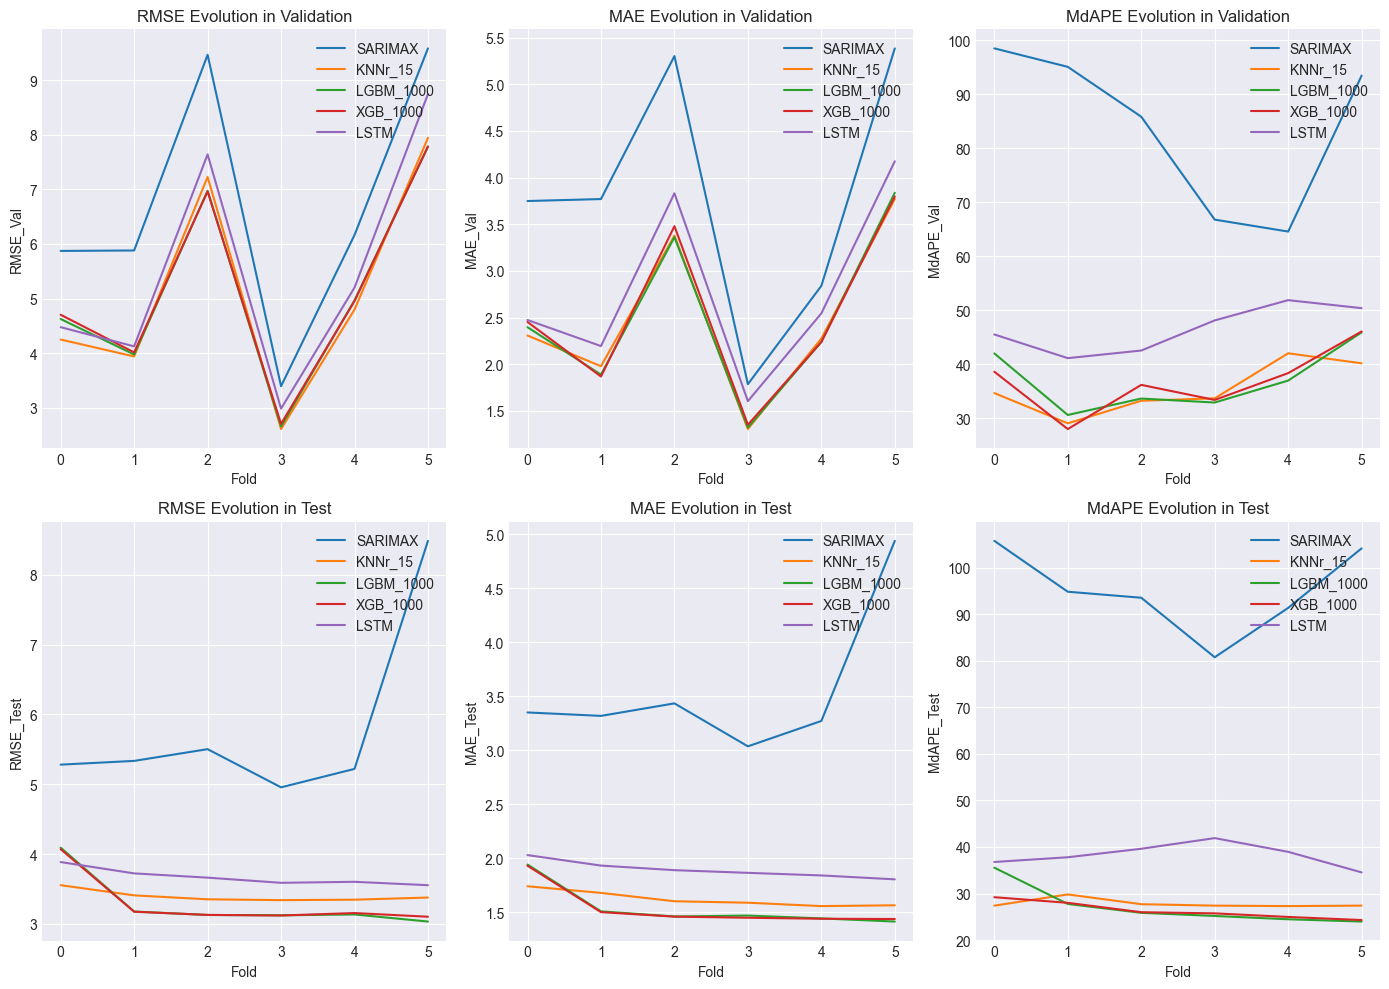

In [564]:
def walkForwardValidation(X, y, X_test, y_test, models, models_names, params, plot=False, fixed_train=False):
    n_splits = params['validation']['n_splits']
    results = pd.DataFrame(columns=["Model", "RMSE_Test", "RMSE_Val", "MAE_Test", "MAE_Val", "MdAPE_Test", "MdAPE_Val", "Mean_MRSE_Test", "Mean_MAE_Test", "Mean_MdAPE_Test","Mean_RMSE_Val", "Mean_MAE_Val", "Mean_MdAPE_Val"])
    y_test = np.expm1(y_test)
    X_sarimax = X[col_names].to_numpy()
    X_test_sarimax = X_test[col_names].to_numpy()
    X, y = X.to_numpy(), y.to_numpy()

    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        if fixed_train:
            tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=X.shape[0] // n_splits)
        else:
            tscv = TimeSeriesSplit(n_splits=n_splits)
            
        rmse_test, rmse_val, mae_test, mae_val, mdape_test, mdape_val = [], [], [], [], [], []
        for train_index, eval_index in tscv.split(X):
            X_train, X_val = X[train_index], X[eval_index]
            y_train, y_val = y[train_index], y[eval_index]
            y_val = np.expm1(y_val)

            if "LSTM" in model_name or "GRU" in model_name:
                train_model(model, X_train, y_train, parameters)
                y_pred_val = model.predict(
                    x = X_val,
                    batch_size = parameters["lstm"]["batch_size"]
                ).flatten()
            elif "SARIMAX" in model_name:
                X_sarimax_train, X_sarimax_val = X_sarimax[train_index], X_sarimax[eval_index]
                SARIMAX_model = SARIMAX(y_train, exog=X_sarimax_train, order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
                model_fit = SARIMAX_model.fit(disp=False)
                forecast = model_fit.get_forecast(steps=len(X_sarimax_val), exog=X_sarimax_val)
                y_pred_val = forecast.predicted_mean 
            else:
                model.fit(X_train, y_train)
                y_pred_val = model.predict(X_val)

            y_pred_val = np.expm1(y_pred_val)
            mae_val.append(mean_absolute_error(y_val, y_pred_val))
            rmse_val.append(root_mean_squared_error(y_val, y_pred_val))
            mdape_val.append(median_absolute_percentage_error(y_val, y_pred_val))

            #Test Scores
            if "LSTM" in model_name or "GRU" in model_name:
                y_pred_test = model.predict(
                    x = X_test,
                    batch_size = parameters["lstm"]["batch_size"]
                ).flatten()

            elif "SARIMAX" in model_name:
                SARIMAX_model = SARIMAX(y_train, exog=X_sarimax_train, order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
                model_fit = SARIMAX_model.fit(disp=False)
                forecast = model_fit.get_forecast(steps=len(X_test_sarimax), exog=X_test_sarimax)
                y_pred_test = forecast.predicted_mean 
            else:
                y_pred_test = model.predict(X_test)

            #Calculate Metrics
            y_pred_test = np.expm1(y_pred_test)
            mae_test.append(mean_absolute_error(y_test, y_pred_test))
            rmse_test.append(root_mean_squared_error(y_test, y_pred_test))
            mdape_test.append(median_absolute_percentage_error(y_test, y_pred_test))

            
        print(f"Model: {model_name} ===> Mean Test MAE: {np.mean(mae_test)}, RMSE: {np.mean(rmse_test)}, MdAPE: {np.mean(mdape_test)}")
        results.loc[len(results.index)] = [model_name, rmse_test, rmse_val, mae_test, mae_val, mdape_test, mdape_val, np.mean(rmse_test), np.mean(mae_test), np.mean(mdape_test), np.mean(rmse_val), np.mean(mae_val), np.mean(mdape_val)] 
    #Plots
    if plot:
        titles = ["RMSE Evolution in Validation", "MAE Evolution in Validation", "MdAPE Evolution in Validation", "RMSE Evolution in Test", "MAE Evolution in Test", "MdAPE Evolution in Test"]
        metric_names = ["RMSE_Val", "MAE_Val", "MdAPE_Val", "RMSE_Test", "MAE_Test", "MdAPE_Test"]
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))
        for i in range(6):
            metric_name = metric_names[i]
            title = titles[i]
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            for _, row in results.iterrows():
                model_name = row["Model"]
                metric_values = row[metric_name]
                ax.plot(metric_values, label=model_name)

            ax.set_title(title)
            ax.set_xlabel("Fold")
            ax.set_ylabel(metric_name)
            ax.legend(loc='upper right')
            ax.grid(True)
        if fixed_train:
            plt.savefig('../results/Sliding_Window_Validation_plot.png', bbox_inches='tight', dpi=300)
        else:
            plt.savefig('../results/Walking_Forward_Validation_plot.png', bbox_inches='tight', dpi=300)
        plt.tight_layout()
        plt.show()
    return results

results = walkForwardValidation(X_train, y_train, X_test, y_test, models, models_names, parameters, plot=True, fixed_train=False)

### Sliding Window Validation

<div align="center">
    <img src="https://i.sstatic.net/QNlQl.png" width=600px>
</div>

 20%|██        | 1/5 [10:09<40:39, 609.82s/it]

Model: SARIMAX ===> Mean Test MAE: 4.238278303189866, RMSE: 8.841668469216769, MdAPE: 101.20021033373985


 40%|████      | 2/5 [10:10<12:33, 251.26s/it]

Model: KNNr_15 ===> Mean Test MAE: 1.7110522637145353, RMSE: 3.5212453618330026, MdAPE: 30.58202192212841


 60%|██████    | 3/5 [10:19<04:41, 140.79s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.8319955460648627, RMSE: 3.6844652587635367, MdAPE: 34.621567442884


 80%|████████  | 4/5 [10:26<01:27, 88.00s/it] 

Model: XGB_1000 ===> Mean Test MAE: 1.7351805002961342, RMSE: 3.5273151113089494, MdAPE: 32.57032550516581
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


100%|██████████| 5/5 [12:27<00:00, 149.43s/it]

Model: LSTM ===> Mean Test MAE: 1.868278900711964, RMSE: 3.641037296127337, MdAPE: 39.08183077971139


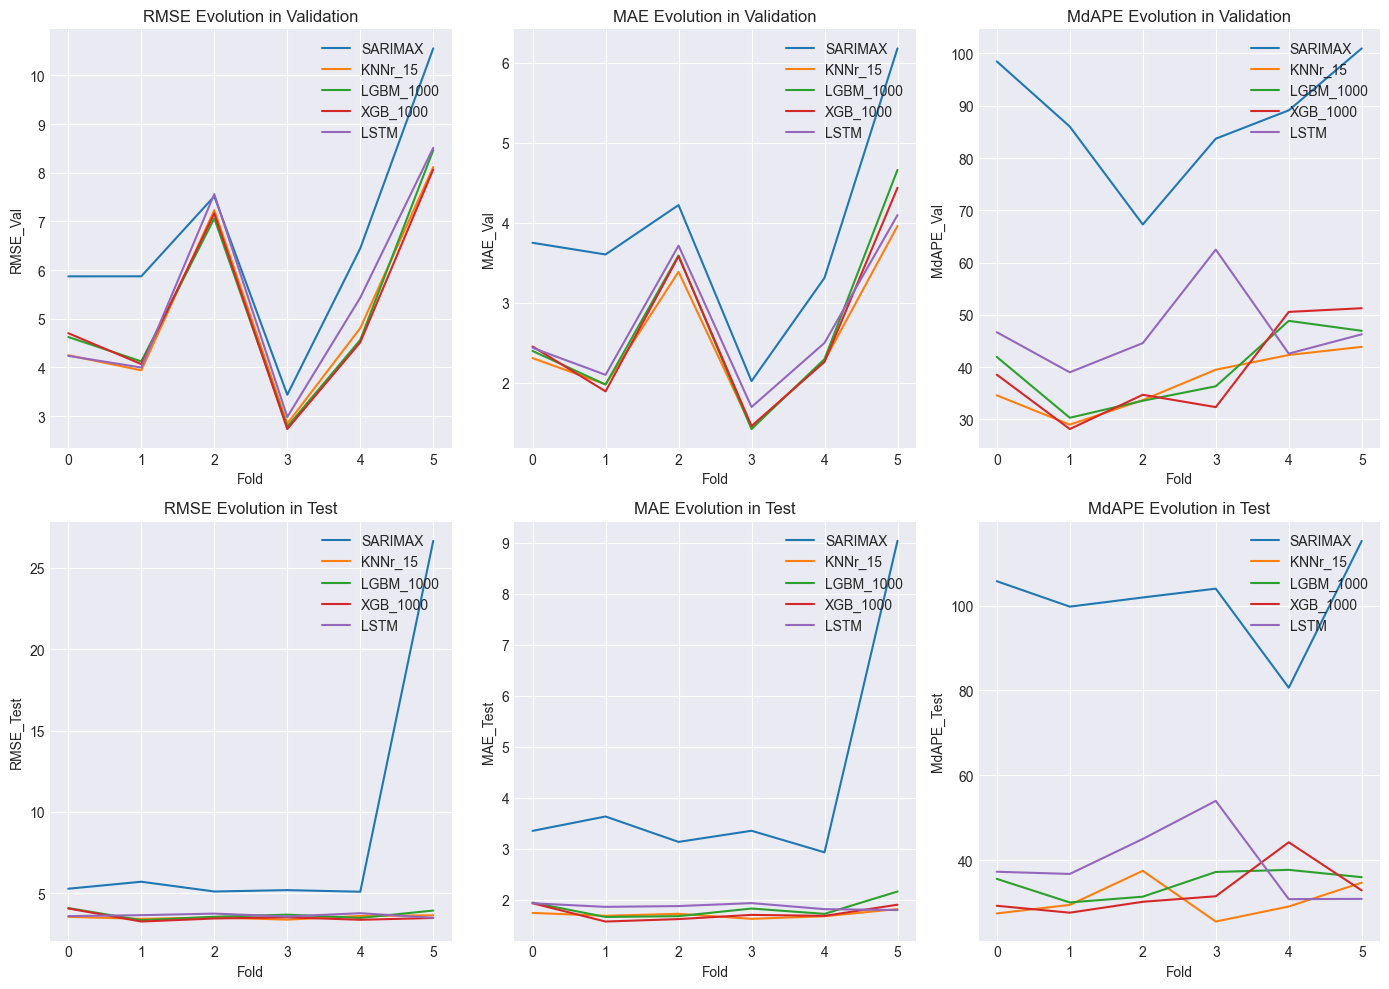

In [565]:
results = walkForwardValidation(X_train, y_train, X_test, y_test, models, models_names, parameters, plot=True, fixed_train=True)

### Grid Search (XGBOOST)

In [566]:
paramsXGB = {
    'max_depth': [7, 8, 9],
    'learning_rate': [0.01, 0.005, 0.003],
    'gamma': [7, 8, 9],
    'colsample_bytree' : [0.7, 0.9, 1],
    'colsample_bynode': [ 0.7, 0.9, 1],
    'n_estimators': [1300]
}

def gridSearchXGB(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        max_depth = param.get('max_depth')
        n_estimators = param.get('n_estimators')
        lr = param.get('learning_rate')
        gamma = param.get('gamma')
        colsample_bytree = param.get('colsample_bytree')
        colsample_bynode = param.get('colsample_bynode')
        regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=n_estimators, learning_rate = lr, max_depth=max_depth, colsample_bytree = colsample_bytree, colsample_bynode = colsample_bynode, gamma=gamma, random_state=123)

        regressorXGBR.fit(
            X = X_train,
            y = y_train,
            verbose=0
        )  
        y_pred = regressorXGBR.predict(X_test)
        
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Max_depth: {max_depth}, Gamma: {gamma}, Col_Sample_By_Tree: {colsample_bytree}, Col_Sample_By_Node: {colsample_bynode}")
    config["mae"] = best_mae
    return config

gridSearchXGB(paramsXGB)

  0%|          | 1/243 [00:05<20:58,  5.20s/it]

MAE: 1.3379446708360252, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  1%|          | 2/243 [00:10<21:32,  5.36s/it]

MAE: 1.3326163193131448, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  1%|          | 3/243 [00:16<21:56,  5.49s/it]

MAE: 1.325959130902127, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  2%|▏         | 4/243 [00:22<23:26,  5.89s/it]

MAE: 1.3303134742667329, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  2%|▏         | 5/243 [00:29<24:31,  6.18s/it]

MAE: 1.3409182417393621, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  2%|▏         | 6/243 [00:36<24:57,  6.32s/it]

MAE: 1.336353007815679, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  3%|▎         | 7/243 [00:42<24:48,  6.31s/it]

MAE: 1.3470632152445063, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  3%|▎         | 8/243 [00:48<23:54,  6.10s/it]

MAE: 1.3481509464340042, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  4%|▎         | 9/243 [00:53<22:53,  5.87s/it]

MAE: 1.340295753839626, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  4%|▍         | 10/243 [00:59<23:14,  5.98s/it]

MAE: 1.3366631516473872, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  5%|▍         | 11/243 [01:05<22:24,  5.80s/it]

MAE: 1.3298770409296967, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  5%|▍         | 12/243 [01:09<20:58,  5.45s/it]

MAE: 1.3336303007138401, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  5%|▌         | 13/243 [01:14<19:35,  5.11s/it]

MAE: 1.3379596048358509, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  6%|▌         | 14/243 [01:18<18:56,  4.96s/it]

MAE: 1.3343353586781441, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  6%|▌         | 15/243 [01:23<18:40,  4.92s/it]

MAE: 1.3399180345509698, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  7%|▋         | 16/243 [01:28<18:20,  4.85s/it]

MAE: 1.3573017951361726, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  7%|▋         | 17/243 [01:32<18:10,  4.82s/it]

MAE: 1.3470845731894956, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  7%|▋         | 18/243 [01:37<18:12,  4.86s/it]

MAE: 1.3615174313157328, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  8%|▊         | 19/243 [01:42<17:38,  4.72s/it]

MAE: 1.3363018502970785, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  8%|▊         | 20/243 [01:47<18:10,  4.89s/it]

MAE: 1.3378023298894692, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  9%|▊         | 21/243 [01:51<17:37,  4.76s/it]

MAE: 1.341996474393594, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  9%|▉         | 22/243 [01:56<17:13,  4.68s/it]

MAE: 1.3530337109734418, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  9%|▉         | 23/243 [02:00<16:37,  4.53s/it]

MAE: 1.3406642980514532, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


 10%|▉         | 24/243 [02:05<16:39,  4.56s/it]

MAE: 1.343864184403069, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


 10%|█         | 25/243 [02:09<16:32,  4.55s/it]

MAE: 1.3559651734772973, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


 11%|█         | 26/243 [02:13<15:52,  4.39s/it]

MAE: 1.3525382811769802, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


 11%|█         | 27/243 [02:18<16:14,  4.51s/it]

MAE: 1.357158587395905, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


 12%|█▏        | 28/243 [02:23<16:06,  4.49s/it]

MAE: 1.321371952491565, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 12%|█▏        | 29/243 [02:27<15:55,  4.46s/it]

MAE: 1.3232200453493537, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 12%|█▏        | 30/243 [02:32<15:59,  4.51s/it]

MAE: 1.3406913188868295, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 13%|█▎        | 31/243 [02:37<16:40,  4.72s/it]

MAE: 1.3298799485510613, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 13%|█▎        | 32/243 [02:41<16:28,  4.68s/it]

MAE: 1.32033520380965, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 14%|█▎        | 33/243 [02:47<16:58,  4.85s/it]

MAE: 1.324283169842519, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 14%|█▍        | 34/243 [02:51<16:41,  4.79s/it]

MAE: 1.3462628131128214, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 14%|█▍        | 35/243 [02:56<16:45,  4.83s/it]

MAE: 1.336793621381651, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 15%|█▍        | 36/243 [03:02<17:14,  5.00s/it]

MAE: 1.3333889752331785, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 15%|█▌        | 37/243 [03:06<16:30,  4.81s/it]

MAE: 1.34894268154263, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 16%|█▌        | 38/243 [03:10<15:49,  4.63s/it]

MAE: 1.3236989295382435, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 16%|█▌        | 39/243 [03:15<15:30,  4.56s/it]

MAE: 1.3364799422213223, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 16%|█▋        | 40/243 [03:19<15:09,  4.48s/it]

MAE: 1.3258669226717819, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 17%|█▋        | 41/243 [03:23<15:06,  4.49s/it]

MAE: 1.3290521671691409, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 17%|█▋        | 42/243 [03:29<15:45,  4.70s/it]

MAE: 1.3456372928267681, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 18%|█▊        | 43/243 [03:33<15:43,  4.72s/it]

MAE: 1.34706668704524, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 18%|█▊        | 44/243 [03:38<15:57,  4.81s/it]

MAE: 1.3393615110249466, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 19%|█▊        | 45/243 [03:43<15:56,  4.83s/it]

MAE: 1.3349622674616635, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 19%|█▉        | 46/243 [03:47<15:16,  4.65s/it]

MAE: 1.341701375736771, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 19%|█▉        | 47/243 [03:52<14:52,  4.56s/it]

MAE: 1.3205356299613462, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 20%|█▉        | 48/243 [03:56<14:49,  4.56s/it]

MAE: 1.3429621724479406, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 20%|██        | 49/243 [04:01<14:43,  4.55s/it]

MAE: 1.3379039170601537, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 21%|██        | 50/243 [04:06<15:07,  4.70s/it]

MAE: 1.330692457214173, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 21%|██        | 51/243 [04:11<14:59,  4.69s/it]

MAE: 1.3583495952076623, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 21%|██▏       | 52/243 [04:15<15:03,  4.73s/it]

MAE: 1.3686141108157823, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 22%|██▏       | 53/243 [04:20<15:06,  4.77s/it]

MAE: 1.3631624560057412, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 22%|██▏       | 54/243 [04:25<15:19,  4.87s/it]

MAE: 1.3666926429595192, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.7


 23%|██▎       | 55/243 [04:30<15:09,  4.84s/it]

MAE: 1.332307163092413, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 23%|██▎       | 56/243 [04:35<15:03,  4.83s/it]

MAE: 1.325930350878643, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 23%|██▎       | 57/243 [04:40<14:59,  4.84s/it]

MAE: 1.3369907734730266, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 24%|██▍       | 58/243 [04:45<14:49,  4.81s/it]

MAE: 1.329301529579413, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 24%|██▍       | 59/243 [04:50<15:03,  4.91s/it]

MAE: 1.3418527843976091, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 25%|██▍       | 60/243 [04:55<15:35,  5.11s/it]

MAE: 1.328606514254665, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 25%|██▌       | 61/243 [05:00<15:29,  5.11s/it]

MAE: 1.3382052338963508, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 26%|██▌       | 62/243 [05:06<15:34,  5.16s/it]

MAE: 1.3360144795161326, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 26%|██▌       | 63/243 [05:11<15:39,  5.22s/it]

MAE: 1.3590955546319985, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 26%|██▋       | 64/243 [05:15<14:34,  4.88s/it]

MAE: 1.3251308582893364, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 27%|██▋       | 65/243 [05:19<13:44,  4.63s/it]

MAE: 1.3243681575278987, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 27%|██▋       | 66/243 [05:23<13:17,  4.51s/it]

MAE: 1.32100979522332, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 28%|██▊       | 67/243 [05:28<13:01,  4.44s/it]

MAE: 1.328043590805446, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 28%|██▊       | 68/243 [05:33<13:21,  4.58s/it]

MAE: 1.3259005335087009, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 28%|██▊       | 69/243 [05:38<14:10,  4.89s/it]

MAE: 1.3320189935153233, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 29%|██▉       | 70/243 [05:43<14:19,  4.97s/it]

MAE: 1.3438876986665345, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 29%|██▉       | 71/243 [05:48<14:08,  4.93s/it]

MAE: 1.3606852437926253, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 30%|██▉       | 72/243 [05:54<15:08,  5.31s/it]

MAE: 1.3428355372004437, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 30%|███       | 73/243 [06:00<15:12,  5.37s/it]

MAE: 1.3462448413481218, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 30%|███       | 74/243 [06:05<14:44,  5.23s/it]

MAE: 1.3258655778759425, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 31%|███       | 75/243 [06:09<14:07,  5.04s/it]

MAE: 1.3230178993376116, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 31%|███▏      | 76/243 [06:14<13:35,  4.88s/it]

MAE: 1.3326779407324991, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 32%|███▏      | 77/243 [06:19<13:35,  4.91s/it]

MAE: 1.3429644170457764, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 32%|███▏      | 78/243 [06:24<13:28,  4.90s/it]

MAE: 1.3494394524079671, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 33%|███▎      | 79/243 [06:28<13:12,  4.83s/it]

MAE: 1.3485559124600668, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 33%|███▎      | 80/243 [06:34<13:23,  4.93s/it]

MAE: 1.3562390103199171, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 33%|███▎      | 81/243 [06:42<16:14,  6.02s/it]

MAE: 1.368552557349283, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.7


 34%|███▎      | 82/243 [06:50<17:12,  6.41s/it]

MAE: 1.3309054471243944, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 34%|███▍      | 83/243 [06:54<15:42,  5.89s/it]

MAE: 1.3282440291343718, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 35%|███▍      | 84/243 [06:59<14:38,  5.52s/it]

MAE: 1.3400160928991207, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 35%|███▍      | 85/243 [07:04<14:01,  5.32s/it]

MAE: 1.3260801121239671, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 35%|███▌      | 86/243 [07:09<13:54,  5.32s/it]

MAE: 1.3286734869914194, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 36%|███▌      | 87/243 [07:14<13:33,  5.21s/it]

MAE: 1.3225155326668052, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 36%|███▌      | 88/243 [07:19<13:26,  5.20s/it]

MAE: 1.3399206249645268, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 37%|███▋      | 89/243 [07:24<13:26,  5.24s/it]

MAE: 1.3407966596892738, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 37%|███▋      | 90/243 [07:30<13:31,  5.31s/it]

MAE: 1.3505073537180685, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 37%|███▋      | 91/243 [07:35<12:52,  5.08s/it]

MAE: 1.3495896916172914, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 38%|███▊      | 92/243 [07:40<12:45,  5.07s/it]

MAE: 1.3364415655514719, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 38%|███▊      | 93/243 [07:45<12:35,  5.04s/it]

MAE: 1.332983528227629, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 39%|███▊      | 94/243 [07:49<12:08,  4.89s/it]

MAE: 1.3276840012965336, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 39%|███▉      | 95/243 [07:54<12:12,  4.95s/it]

MAE: 1.3300960232520078, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 40%|███▉      | 96/243 [07:59<12:06,  4.94s/it]

MAE: 1.3284976137937685, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 40%|███▉      | 97/243 [08:04<11:56,  4.91s/it]

MAE: 1.3490970792593213, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 40%|████      | 98/243 [08:09<11:52,  4.91s/it]

MAE: 1.3446929277282171, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 41%|████      | 99/243 [08:15<12:57,  5.40s/it]

MAE: 1.3387307942688387, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 41%|████      | 100/243 [08:20<12:40,  5.32s/it]

MAE: 1.3412382871015749, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 42%|████▏     | 101/243 [08:26<12:30,  5.28s/it]

MAE: 1.3416643454983639, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 42%|████▏     | 102/243 [08:30<11:53,  5.06s/it]

MAE: 1.3446643616394227, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 42%|████▏     | 103/243 [08:35<11:20,  4.86s/it]

MAE: 1.336084056596578, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 43%|████▎     | 104/243 [08:39<10:46,  4.65s/it]

MAE: 1.3456969916197714, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 43%|████▎     | 105/243 [08:43<10:41,  4.65s/it]

MAE: 1.3431759106666705, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 44%|████▎     | 106/243 [08:48<10:42,  4.69s/it]

MAE: 1.35500763909994, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 44%|████▍     | 107/243 [08:53<10:41,  4.71s/it]

MAE: 1.3496620621820972, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 44%|████▍     | 108/243 [08:59<11:21,  5.05s/it]

MAE: 1.3675598020147115, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.9


 45%|████▍     | 109/243 [09:04<11:09,  5.00s/it]

MAE: 1.3188245349908954, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 45%|████▌     | 110/243 [09:09<11:26,  5.16s/it]

MAE: 1.3291496934498166, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 46%|████▌     | 111/243 [09:15<11:47,  5.36s/it]

MAE: 1.3306337223377382, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 46%|████▌     | 112/243 [09:20<11:41,  5.35s/it]

MAE: 1.330019802754489, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 47%|████▋     | 113/243 [09:27<12:14,  5.65s/it]

MAE: 1.330985391213298, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 47%|████▋     | 114/243 [09:33<12:44,  5.93s/it]

MAE: 1.3279977383816188, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 47%|████▋     | 115/243 [09:39<12:38,  5.93s/it]

MAE: 1.3536698883828864, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 48%|████▊     | 116/243 [09:45<12:32,  5.92s/it]

MAE: 1.3358036681009424, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 48%|████▊     | 117/243 [09:51<12:37,  6.01s/it]

MAE: 1.3350102850576981, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 49%|████▊     | 118/243 [09:57<12:11,  5.85s/it]

MAE: 1.3401080570672754, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 49%|████▉     | 119/243 [10:02<11:37,  5.62s/it]

MAE: 1.327457045609322, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 49%|████▉     | 120/243 [10:06<10:49,  5.28s/it]

MAE: 1.3310716648483127, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 50%|████▉     | 121/243 [10:11<10:25,  5.12s/it]

MAE: 1.330337731979543, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 50%|█████     | 122/243 [10:16<10:09,  5.03s/it]

MAE: 1.3287501977147549, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 51%|█████     | 123/243 [10:21<10:18,  5.16s/it]

MAE: 1.354170919394724, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 51%|█████     | 124/243 [10:27<10:17,  5.19s/it]

MAE: 1.3572922360455912, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 51%|█████▏    | 125/243 [10:32<10:32,  5.36s/it]

MAE: 1.3466059413432192, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 52%|█████▏    | 126/243 [10:38<10:40,  5.47s/it]

MAE: 1.3654342450881896, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 52%|█████▏    | 127/243 [10:43<10:08,  5.24s/it]

MAE: 1.3333570843622413, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 53%|█████▎    | 128/243 [10:48<09:45,  5.09s/it]

MAE: 1.326605362138985, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 53%|█████▎    | 129/243 [10:52<09:19,  4.91s/it]

MAE: 1.3245872503659013, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 53%|█████▎    | 130/243 [10:57<09:06,  4.83s/it]

MAE: 1.3291917456244582, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 54%|█████▍    | 131/243 [11:02<09:20,  5.01s/it]

MAE: 1.3453117479908008, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 54%|█████▍    | 132/243 [11:07<09:23,  5.08s/it]

MAE: 1.3216824438156989, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 55%|█████▍    | 133/243 [11:12<09:08,  4.99s/it]

MAE: 1.35578707348259, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 55%|█████▌    | 134/243 [11:17<09:11,  5.06s/it]

MAE: 1.3494167231871776, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 56%|█████▌    | 135/243 [11:23<09:10,  5.10s/it]

MAE: 1.368361039858627, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 0.9


 56%|█████▌    | 136/243 [11:27<08:51,  4.97s/it]

MAE: 1.328856826798679, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 56%|█████▋    | 137/243 [11:32<08:49,  5.00s/it]

MAE: 1.33383213281257, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 57%|█████▋    | 138/243 [11:38<08:49,  5.05s/it]

MAE: 1.3468644440208437, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 57%|█████▋    | 139/243 [11:43<08:43,  5.03s/it]

MAE: 1.3374240517737923, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 58%|█████▊    | 140/243 [11:48<08:48,  5.13s/it]

MAE: 1.3291914332288173, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 58%|█████▊    | 141/243 [11:54<09:09,  5.38s/it]

MAE: 1.326873809255822, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 58%|█████▊    | 142/243 [11:59<09:07,  5.43s/it]

MAE: 1.3428100895493258, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 59%|█████▉    | 143/243 [12:06<09:33,  5.73s/it]

MAE: 1.3473088813579095, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 59%|█████▉    | 144/243 [12:13<10:24,  6.31s/it]

MAE: 1.3368518218667742, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 60%|█████▉    | 145/243 [12:18<09:37,  5.90s/it]

MAE: 1.3619586524294243, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 60%|██████    | 146/243 [12:23<08:58,  5.55s/it]

MAE: 1.3163060625273244, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 60%|██████    | 147/243 [12:28<08:38,  5.40s/it]

MAE: 1.335037888252109, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 61%|██████    | 148/243 [12:33<08:10,  5.16s/it]

MAE: 1.3414539188351495, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 61%|██████▏   | 149/243 [12:38<08:05,  5.16s/it]

MAE: 1.356078778445431, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 62%|██████▏   | 150/243 [12:44<08:19,  5.37s/it]

MAE: 1.3294966052056283, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 62%|██████▏   | 151/243 [12:49<08:12,  5.35s/it]

MAE: 1.3459386530931714, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 63%|██████▎   | 152/243 [12:55<08:27,  5.58s/it]

MAE: 1.3621595533988051, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 63%|██████▎   | 153/243 [13:01<08:26,  5.63s/it]

MAE: 1.3357353080594982, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 63%|██████▎   | 154/243 [13:06<07:57,  5.37s/it]

MAE: 1.3296618870001173, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 64%|██████▍   | 155/243 [13:11<07:43,  5.27s/it]

MAE: 1.3527347207897873, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 64%|██████▍   | 156/243 [13:16<07:36,  5.24s/it]

MAE: 1.3232581758795827, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 65%|██████▍   | 157/243 [13:21<07:34,  5.29s/it]

MAE: 1.3535368957510538, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 65%|██████▌   | 158/243 [13:27<07:41,  5.43s/it]

MAE: 1.3197744643325984, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 65%|██████▌   | 159/243 [13:32<07:17,  5.21s/it]

MAE: 1.328921000899176, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 66%|██████▌   | 160/243 [13:38<07:32,  5.45s/it]

MAE: 1.3426676112020544, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 66%|██████▋   | 161/243 [13:44<07:50,  5.74s/it]

MAE: 1.3727955154430762, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 67%|██████▋   | 162/243 [13:51<07:57,  5.90s/it]

MAE: 1.3637507995481806, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 0.9


 67%|██████▋   | 163/243 [13:56<07:31,  5.64s/it]

MAE: 1.3360178463871821, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 67%|██████▋   | 164/243 [14:01<07:13,  5.49s/it]

MAE: 1.33820248041045, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 68%|██████▊   | 165/243 [14:06<06:57,  5.35s/it]

MAE: 1.3204074216026012, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 68%|██████▊   | 166/243 [14:11<06:48,  5.30s/it]

MAE: 1.3255811156004194, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 69%|██████▊   | 167/243 [14:16<06:48,  5.38s/it]

MAE: 1.3283589725716554, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 69%|██████▉   | 168/243 [14:22<06:48,  5.44s/it]

MAE: 1.331023363155979, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 70%|██████▉   | 169/243 [14:27<06:38,  5.39s/it]

MAE: 1.3497511177762285, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 70%|██████▉   | 170/243 [14:33<06:31,  5.36s/it]

MAE: 1.335220608798033, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 70%|███████   | 171/243 [14:38<06:24,  5.34s/it]

MAE: 1.3348070857330587, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 71%|███████   | 172/243 [14:43<06:05,  5.15s/it]

MAE: 1.3274184688466726, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 71%|███████   | 173/243 [14:47<05:53,  5.06s/it]

MAE: 1.3255379465639485, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 72%|███████▏  | 174/243 [14:52<05:43,  4.98s/it]

MAE: 1.3389682357811779, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 72%|███████▏  | 175/243 [14:57<05:29,  4.85s/it]

MAE: 1.326645881885171, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 72%|███████▏  | 176/243 [15:02<05:41,  5.09s/it]

MAE: 1.3517104124197523, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 73%|███████▎  | 177/243 [15:08<05:40,  5.16s/it]

MAE: 1.3326865622215542, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 73%|███████▎  | 178/243 [15:13<05:31,  5.10s/it]

MAE: 1.3482506935336618, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 74%|███████▎  | 179/243 [15:18<05:27,  5.12s/it]

MAE: 1.3388483418767225, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 74%|███████▍  | 180/243 [15:23<05:27,  5.20s/it]

MAE: 1.338989557048301, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 74%|███████▍  | 181/243 [15:28<05:16,  5.10s/it]

MAE: 1.3414255995690096, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 75%|███████▍  | 182/243 [15:33<05:07,  5.04s/it]

MAE: 1.3479642734046262, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 75%|███████▌  | 183/243 [15:38<04:53,  4.90s/it]

MAE: 1.3364260857000887, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 76%|███████▌  | 184/243 [15:42<04:44,  4.82s/it]

MAE: 1.340548642606501, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 76%|███████▌  | 185/243 [15:47<04:40,  4.83s/it]

MAE: 1.358745017400808, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 77%|███████▋  | 186/243 [15:52<04:29,  4.72s/it]

MAE: 1.3236892875561097, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 77%|███████▋  | 187/243 [15:56<04:21,  4.66s/it]

MAE: 1.3539134594533722, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 77%|███████▋  | 188/243 [16:01<04:25,  4.82s/it]

MAE: 1.3523929918338229, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 78%|███████▊  | 189/243 [16:07<04:27,  4.94s/it]

MAE: 1.3473379302298263, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 1


 78%|███████▊  | 190/243 [16:12<04:29,  5.09s/it]

MAE: 1.3347694856334098, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 79%|███████▊  | 191/243 [16:17<04:31,  5.22s/it]

MAE: 1.3293795918327627, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 79%|███████▉  | 192/243 [16:23<04:37,  5.45s/it]

MAE: 1.3357499837944737, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 79%|███████▉  | 193/243 [16:29<04:33,  5.46s/it]

MAE: 1.3415643920379927, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 80%|███████▉  | 194/243 [16:35<04:31,  5.54s/it]

MAE: 1.3245845559754246, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 80%|████████  | 195/243 [16:40<04:29,  5.62s/it]

MAE: 1.3585067483506295, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 81%|████████  | 196/243 [16:46<04:26,  5.67s/it]

MAE: 1.3469981993830074, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 81%|████████  | 197/243 [16:52<04:23,  5.72s/it]

MAE: 1.3430108548667246, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 81%|████████▏ | 198/243 [16:59<04:30,  6.00s/it]

MAE: 1.3357437203895808, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 82%|████████▏ | 199/243 [17:04<04:10,  5.69s/it]

MAE: 1.3316095680148212, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 82%|████████▏ | 200/243 [17:09<03:54,  5.44s/it]

MAE: 1.3398763020327633, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 83%|████████▎ | 201/243 [17:14<03:45,  5.38s/it]

MAE: 1.3236761648098954, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 83%|████████▎ | 202/243 [17:19<03:34,  5.24s/it]

MAE: 1.337295639370539, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 84%|████████▎ | 203/243 [17:24<03:32,  5.32s/it]

MAE: 1.3376724064446992, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 84%|████████▍ | 204/243 [17:30<03:30,  5.40s/it]

MAE: 1.342011915183335, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 84%|████████▍ | 205/243 [17:35<03:22,  5.33s/it]

MAE: 1.3490390995293415, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 85%|████████▍ | 206/243 [17:40<03:18,  5.36s/it]

MAE: 1.3598355666743103, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 85%|████████▌ | 207/243 [17:46<03:15,  5.44s/it]

MAE: 1.33876387722287, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 86%|████████▌ | 208/243 [17:51<03:00,  5.15s/it]

MAE: 1.330917738398941, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 86%|████████▌ | 209/243 [17:56<02:55,  5.16s/it]

MAE: 1.3343215079348851, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 86%|████████▋ | 210/243 [18:00<02:46,  5.05s/it]

MAE: 1.3319732642785858, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 87%|████████▋ | 211/243 [18:05<02:34,  4.81s/it]

MAE: 1.3348094162891844, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 87%|████████▋ | 212/243 [18:10<02:30,  4.87s/it]

MAE: 1.3419565667617288, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 88%|████████▊ | 213/243 [18:16<02:34,  5.14s/it]

MAE: 1.329616964968416, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 88%|████████▊ | 214/243 [18:21<02:33,  5.28s/it]

MAE: 1.3563606742378636, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 88%|████████▊ | 215/243 [18:27<02:30,  5.36s/it]

MAE: 1.3578744805762348, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 89%|████████▉ | 216/243 [18:32<02:28,  5.49s/it]

MAE: 1.3349995168506534, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 0.9, Col_Sample_By_Node: 1


 89%|████████▉ | 217/243 [18:37<02:14,  5.17s/it]

MAE: 1.3246388668566922, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 90%|████████▉ | 218/243 [18:42<02:06,  5.06s/it]

MAE: 1.3263115812530457, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 90%|█████████ | 219/243 [18:47<02:04,  5.17s/it]

MAE: 1.3654340466831203, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 91%|█████████ | 220/243 [18:52<01:57,  5.09s/it]

MAE: 1.331095210743992, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 91%|█████████ | 221/243 [18:57<01:52,  5.11s/it]

MAE: 1.3237231941828633, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 91%|█████████▏| 222/243 [19:03<01:51,  5.30s/it]

MAE: 1.3461035196338285, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 92%|█████████▏| 223/243 [19:09<01:51,  5.59s/it]

MAE: 1.3537908838545327, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 92%|█████████▏| 224/243 [19:15<01:49,  5.76s/it]

MAE: 1.3349630249963218, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 93%|█████████▎| 225/243 [19:21<01:45,  5.86s/it]

MAE: 1.3605083480728246, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 7, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 93%|█████████▎| 226/243 [19:26<01:33,  5.48s/it]

MAE: 1.3227912886631175, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 93%|█████████▎| 227/243 [19:31<01:24,  5.31s/it]

MAE: 1.3464378111620525, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 94%|█████████▍| 228/243 [19:36<01:17,  5.18s/it]

MAE: 1.3333681263648454, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 94%|█████████▍| 229/243 [19:41<01:13,  5.26s/it]

MAE: 1.359195441177872, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 95%|█████████▍| 230/243 [19:47<01:11,  5.47s/it]

MAE: 1.344032053106706, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 95%|█████████▌| 231/243 [19:53<01:07,  5.59s/it]

MAE: 1.3804872588606791, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 95%|█████████▌| 232/243 [19:59<01:02,  5.69s/it]

MAE: 1.3625129688529616, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 96%|█████████▌| 233/243 [20:06<01:00,  6.00s/it]

MAE: 1.3386714313651265, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 96%|█████████▋| 234/243 [20:13<00:56,  6.24s/it]

MAE: 1.3547194796149218, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 8, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 97%|█████████▋| 235/243 [20:18<00:48,  6.06s/it]

MAE: 1.3502733730650616, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 97%|█████████▋| 236/243 [20:24<00:42,  6.05s/it]

MAE: 1.3319943836335082, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 98%|█████████▊| 237/243 [20:30<00:35,  5.98s/it]

MAE: 1.3392091225354468, n_Estimators: 1300, Learning_rate: 0.01, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 98%|█████████▊| 238/243 [20:36<00:29,  5.92s/it]

MAE: 1.3436348148000155, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 98%|█████████▊| 239/243 [20:42<00:23,  5.98s/it]

MAE: 1.3446605013947808, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 99%|█████████▉| 240/243 [20:49<00:18,  6.19s/it]

MAE: 1.3740379062624009, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


 99%|█████████▉| 241/243 [20:54<00:12,  6.05s/it]

MAE: 1.350326569876579, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 7, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


100%|█████████▉| 242/243 [21:01<00:06,  6.16s/it]

MAE: 1.3545637059781417, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 8, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


100%|██████████| 243/243 [21:08<00:00,  5.22s/it]

MAE: 1.3776969204357703, n_Estimators: 1300, Learning_rate: 0.003, Max_depth: 9, Gamma: 9, Col_Sample_By_Tree: 1, Col_Sample_By_Node: 1


{'colsample_bynode': 0.9,
 'colsample_bytree': 1,
 'gamma': 8,
 'learning_rate': 0.01,
 'max_depth': 8,
 'n_estimators': 1300,
 'mae': 1.3163060625273244}

### Grid Search (LightGBM)

In [567]:
params = {
    'num_leaves': [10, 20, 30, 40],
    'learning_rate': [0.05, 0.01, 0.005],
    'colsample_bytree' : [0.7, 0.9, 1],
    'n_estimators': [1200],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]
}

def gridSearchLGBM(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        n_estimators = param.get('n_estimators')
        num_leaves = param.get('num_leaves')
        lr = param.get('learning_rate')
        reg_alpha = param.get('reg_alpha')
        colsample_bytree = param.get('colsample_bytree')
        LGBMReg = LGBMRegressor(boosting_type='gbdt', n_estimators=n_estimators, learning_rate=lr, random_state=123, reg_alpha=reg_alpha, n_jobs=-1, verbose=-1, num_leaves=num_leaves) 
        LGBMReg.fit(
            X = X_train,
            y = y_train,
        ) 
        y_pred = LGBMReg.predict(X_test)
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Num_leaves: {num_leaves}, Col_Sample_By_Tree: {colsample_bytree}, reg_alpha: {reg_alpha}")
    config["mae"] = best_mae
    return config
#gridSearchLGBM(params)

### Feature Importance 

In [568]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1300, learning_rate = 0.005, max_depth=9, colsample_bytree = .9, colsample_bynode = .9, gamma=7, random_state=123)
regressorXGBR.fit(
    X = X_train,
    y = y_train,
    verbose=0
)
y_pred = regressorXGBR.predict(X_test)

mae, rmse, mdape, maape = calculate_metrics(np.expm1(y_test), np.expm1(y_pred))
print(f"MAE: {mae}, RMSE: {rmse}, MdAPE: {mdape}, MAAPE: {maape}")

imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=col_names, columns=['importance'])
imp_df.sort_values(by=["importance"])

MAE: 1.3279977383816188, RMSE: 3.1045641331256673, MdAPE: 27.596873044967634, MAAPE: 45.62428179762234


importance
diffuse_radiation_W/m2           0.024305
lag_5                            0.027940
temperature_2m_C                 0.028203
lag_3                            0.028574
lag_4                            0.029424
shortwave_radiation_W/m2         0.029738
Month_cos                        0.030456
lag_6                            0.039517
isWeekend                        0.041857
Hour_sin                         0.042469
Hour                             0.043529
lag_2                            0.043913
DayOfWeek_sin                    0.047879
direct_normal_irradiance_W/m2    0.049037
isHoliday                        0.056209
Hour_cos                         0.072501
lag_7                            0.162404
lag_1                            0.202045

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:00<00:00, 26.33it/s]


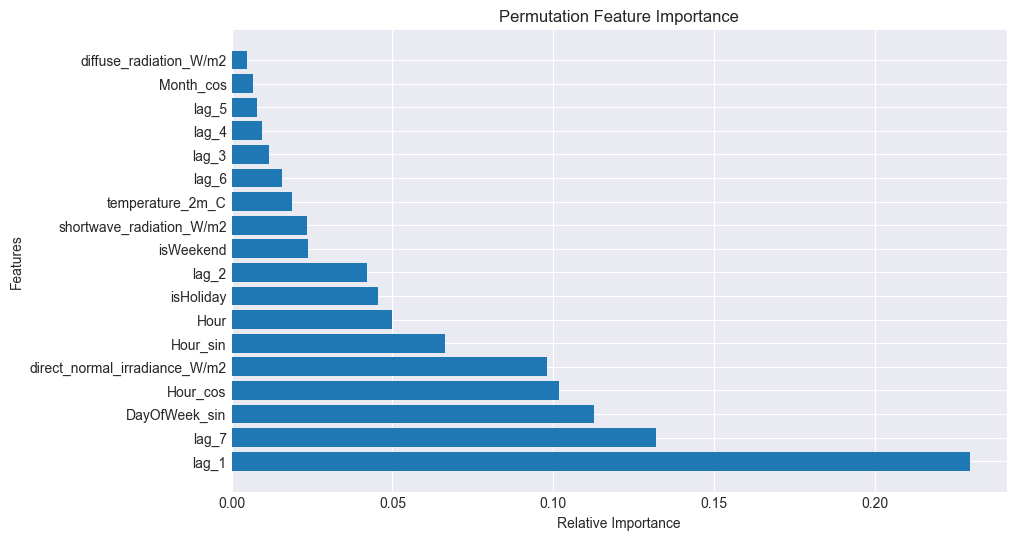

In [569]:
permutation_feature_importance(regressorXGBR, X_test.to_numpy(), y_test, np.array(col_names))

### Plot Prediction Results

In [570]:
plotPredictions(X_test_dates, np.expm1(y_pred), np.expm1(y_test), "predictions_Test_All")

In [571]:
plotPredictions(X_test_dates[:30*24], np.expm1(y_pred[:30*24]), np.expm1(y_test[:30*24]), "predictions_Test_Month")

In [572]:
plotPredictions(X_test_dates[:24*7], np.expm1(y_pred[:24*7]), np.expm1(y_test[:24*7]), "predictions_Test_Week")

In [573]:
print(f"Test Demand Min: {np.min(np.expm1(y_test))} - Max: {np.max(np.expm1(y_test))}")
print(f"Predicted Demand Min: {np.min(np.expm1(y_pred))} - Max: {np.max(np.expm1(y_pred))}")

Test Demand Min: 0.0 - Max: 45.0
Predicted Demand Min: -0.08703982084989548 - Max: 18.50042724609375
